In [2]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skewnorm as sn
import scipy.special as sp
import seaborn as sns
from seaborn import kdeplot
from sklearn.neighbors import KernelDensity
plt.rc('font', size=12.0)

In [3]:
nsrc = ['6304', '6397', 'M13', 'M28', 'M30', 'wCen', 'X7', '1810b', '1724b', '1702', '0030', '0740']
pstr = ['J0453p','J0453c','J1906p','J1906c','B1534p',  'B1534c','B1913p','B1913c',
      'B2127p','B2127c','J0737A','J0737B','J1756p',  'J1756c','J1807p','J1807c',
      'J1518p','J1518c','J1811p','J1811c','J1829p',  'J1829c','J2045', 'J2053',
      'J1713', 'B1855', 'J0751', 'J1141', 'J1738',   'J1614', 'J0348', 'J2222', 'J2234',
      'J1949', 'J1012', 'J0437', 'J1909', 'J1802',   'J1911', 'J2043', 'J0337', 'J1946',
      'J1918', 'J1600', 'J0621', 'B2303', 'J0024',   'J0514', 'B1516', 'J1748I','J1748J',
      'B1802', 'B1911', 'J0740', 'CygX2', 'XTEJ2123','4U1822','HerX1', '2S0921']

m_nsp, r_nsp, m_src, r_src = [], [], [], []

for k, star in enumerate(nsrc):
    m_src.append('Mns_'+nsrc[k])
for k, star in enumerate(nsrc):
    r_src.append('Rns_'+nsrc[k])
for k, star in enumerate(pstr):
    m_nsp.append('M_'+pstr[k])

## $M-R$ Curves

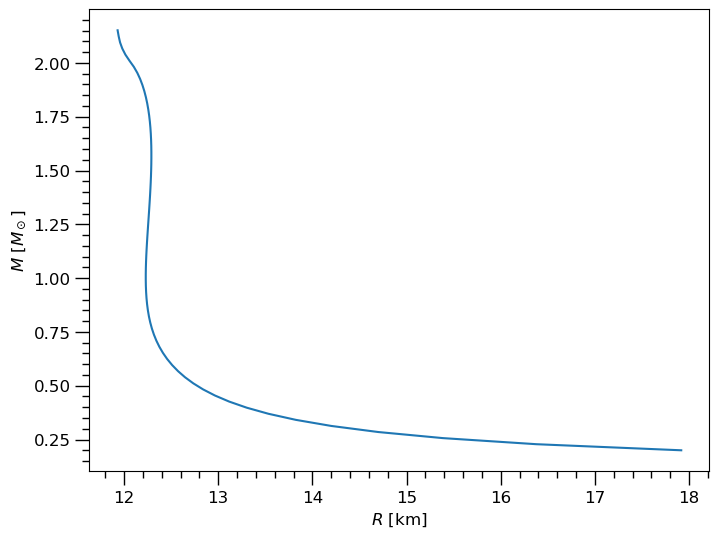

In [4]:
mchain = h5py.File('aff_inv/np_all','r')['markov_chain_0']
mult = np.array(mchain['data']['mult'])
r = [None] * 100  # Initialize r as a list to hold arrays

for i in range(100):
  r[i] = np.array(mchain['data']['R_'+str(i)])
  r[i] = r[i][np.nonzero(r[i])].tolist() 
  if r[i]==[]:
    r[i] = 0
  else:
    r[i] = np.mean(r[i])
r = np.array(r)[np.nonzero(np.array(r))]
m = np.arange(0.2, 0.2+((3-0.2)/99)*len(r), ((3-0.2)/99))
mmax = np.mean(np.array(mchain['data']['M_max']))
for i in range(len(m)):
   if m[i] > mmax:
      m[i] = 0
      r[i] = 0
r = r[np.nonzero(r)]
m = m[np.nonzero(m)]

plt.figure(figsize=(8,6))
plt.plot(r, m)
plt.xlabel(r'$R~[\mathrm{km}]$')
plt.ylabel(r'$M~[M_\odot]$')
plt.minorticks_on()
plt.tick_params('both', length=10, width=1, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.show()

In [28]:
fig, ax = plt.subplots(2, 2)
model = ['ml', 'mp', 'nl', 'np']
for k in range(4):
    mchain = h5py.File(model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    r = np.zeros((100, nrows))
    for i in range(100):
        r[i] = np.array(mchain['data']['R_'+str(i)])
    r=r.T
    m = np.arange(0.2, 0.2+((3-0.2)/99)*r.shape[1], ((3-0.2)/99))
    M_gw, R_gw = np.zeros((4, nrows)), np.zeros((4, nrows))
    M_gw[0] = np.array(mchain['data/m1_gw17'])
    M_gw[1] = np.array(mchain['data/m2_gw17'])
    M_gw[2] = np.array(mchain['data/m1_gw19'])
    M_gw[3] = np.array(mchain['data/m2_gw19'])
    M_nsp, R_nsp = np.zeros((len(m_nsp), nrows)), np.zeros((len(m_nsp), nrows))
    M_src, R_src = np.zeros((len(m_src), nrows)), np.zeros((len(m_src), nrows))
    for j in range(4):
        for i in range(nrows):
            R_gw[j][i] = np.interp(M_gw[j][i], m, r[i])
    for j in range(len(m_nsp)):
        M_nsp[j] = np.array(mchain['data/'+m_nsp[j]])
        for i in range(nrows):
            R_nsp[j][i] = np.interp(M_nsp[j][i], m, r[i])
    for j in range(len(m_src)):
        M_src[j] = np.array(mchain['data/'+m_src[j]])
        R_src[j] = np.array(mchain['data/'+r_src[j]])
    M = np.concatenate((M_gw, M_nsp, M_src), axis=0).flatten()
    R = np.concatenate((R_gw, R_nsp, R_src), axis=0).flatten()
    if k==0:
        h1 = sns.kdeplot(x=R, y=M, ax=ax[0,0], fill=True, cmap='viridis')
        ax[0,0].set_title('ML')
        fig.colorbar(h1.collections[0], ax=ax[0,0])
    elif k==1:
        h2 = sns.kdeplot(x=R, y=M, ax=ax[0,1], fill=True, cmap='viridis')
        ax[0,1].set_title('MP')
        fig.colorbar(h2.collections[0], ax=ax[0,1])
    elif k==2:
        h3 = sns.kdeplot(x=R, y=M, ax=ax[1,0], fill=True, cmap='viridis')
        ax[1,0].set_title('NL')
        fig.colorbar(h3.collections[0], ax=ax[1,0])
    elif k==3:
        h4 = sns.kdeplot(x=R, y=M, ax=ax[1,1], fill=True, cmap='viridis')
        ax[1,1].set_title('NP')
        fig.colorbar(h4.collections[0], ax=ax[1,1])

for i in range(2):
    for j in range(2):
        #ax[i,j].set_xlim(10.0, max(R))
        #ax[i,j].set_ylim(min(M), 2.2)
        ax[i,j].minorticks_on()
        ax[i,j].tick_params('both', length=10, width=1, which='major')
        ax[i,j].tick_params('both', length=5,  width=1, which='minor')

fig.tight_layout()
fig.text(0.5, 0.04, r'Radius [km]',      ha='center', va='center')
fig.text(0.04, 0.5, r'Mass [$M_\odot$]', ha='center', va='center', rotation='vertical')
plt.show()

## Equations of State

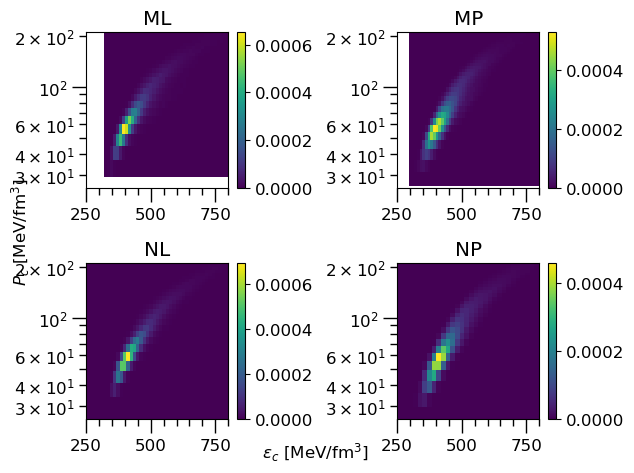

In [38]:
fig, ax = plt.subplots(2, 2)
model = ['ml', 'mp', 'nl', 'np']
for k in range(4):
    mchain = h5py.File(model[k]+'_all','r')['markov_chain_0']
    mmax = np.array(mchain['data']['M_max'])
    nrows = len(mmax)
    pm, p = np.zeros((100, nrows)), np.zeros((100, nrows))
    for i in range(100):
        pm[i] = np.array(mchain['data']['PM_'+str(i)])*197.32698
        p[i] = np.array(mchain['data']['P_'+str(i)])*197.32698
    pm=pm.T; p=p.T
    m = np.arange(0.2, 0.2+((3-0.2)/99)*pm.shape[1], (3-0.2)/99)
    e = np.arange(0.3*197.32698, 0.3*197.32698+((10-0.3)*197.32698/99)*pm.shape[1], (10-0.3)*197.32698/99)
    M_gw, M_nsp, M_src = np.zeros((4,nrows)), np.zeros((len(m_nsp),nrows)), np.zeros((len(m_src),nrows))
    PM_gw, P_gw, E_gw = np.zeros_like(M_gw), np.zeros_like(M_gw), np.zeros_like(M_gw)
    PM_nsp, P_nsp, E_nsp = np.zeros_like(M_nsp), np.zeros_like(M_nsp), np.zeros_like(M_nsp)
    PM_src, P_src, E_src = np.zeros_like(M_src), np.zeros_like(M_src), np.zeros_like(M_src)
    M_gw[0] = np.array(mchain['data/m1_gw17'])
    M_gw[1] = np.array(mchain['data/m2_gw17'])
    M_gw[2] = np.array(mchain['data/m1_gw19'])
    M_gw[3] = np.array(mchain['data/m2_gw19'])
    for j in range(4):
        for i in range(nrows):
            P_gw[j][i] = np.interp(M_gw[j][i], m, pm[i])
            E_gw[j][i] = np.interp(P_gw[j][i], p[i], e)
    for j in range(len(m_nsp)):
        M_nsp[j] = np.array(mchain['data/'+m_nsp[j]])
        for i in range(nrows):
            P_nsp[j][i] = np.interp(M_nsp[j][i], m, pm[i])
            E_nsp[j][i] = np.interp(P_nsp[j][i], p[i], e)
    for j in range(len(m_src)):
        M_src[j] = np.array(mchain['data/'+m_src[j]])
        for i in range(nrows):
            P_src[j][i] = np.interp(M_src[j][i], m, pm[i])
            E_src[j][i] = np.interp(P_src[j][i], p[i], e)
    P = np.concatenate((P_gw, P_nsp, P_src), axis=0).flatten()
    E = np.concatenate((E_gw, E_nsp, E_src), axis=0).flatten()
    if k==0:
        #h1 = sns.kdeplot(x=E, y=P, ax=ax[0,0], fill=True, cmap='viridis')
        h1 = ax[0,0].hist2d(E, P, bins=100, cmap='viridis', density=True)
        ax[0,0].set_title('ML')
        #fig.colorbar(h1.collections[0], ax=ax[0,0])
        fig.colorbar(h1[3], ax=ax[0,0])

    elif k==1:
        #h2 = sns.kdeplot(x=E, y=P, ax=ax[0,1], fill=True, cmap='viridis')
        h2 = ax[0,1].hist2d(E, P, bins=100, cmap='viridis', density=True)
        ax[0,1].set_title('MP')
        #fig.colorbar(h2.collections[0], ax=ax[0,1])
        fig.colorbar(h2[3], ax=ax[0,1])
    elif k==2:
        #h3 = sns.kdeplot(x=E, y=P, ax=ax[1,0], fill=True, cmap='viridis')
        h3 = ax[1,0].hist2d(E, P, bins=100, cmap='viridis', density=True)
        ax[1,0].set_title('NL')
        #fig.colorbar(h3.collections[0], ax=ax[1,0])
        fig.colorbar(h3[3], ax=ax[1,0])
    elif k==3:
        #h4 = sns.kdeplot(x=E, y=P, ax=ax[1,1], fill=True, cmap='viridis')
        h4 = ax[1,1].hist2d(E, P, bins=100, cmap='viridis', density=True)
        ax[1,1].set_title('NP')
        #fig.colorbar(h4.collections[0], ax=ax[1,1])
        fig.colorbar(h4[3], ax=ax[1,1])

for i in range(2):
    for j in range(2):
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim(250, 800)
        ax[i,j].set_ylim(2.5e1, 2.1e2)
        ax[i,j].minorticks_on()
        ax[i,j].tick_params('both', length=10, width=1, which='major')
        ax[i,j].tick_params('both', length=5,  width=1, which='minor')

fig.tight_layout()
fig.text(0.5, 0.04, r'$\epsilon_c$ [MeV/fm$^3$]', ha='center', va='center')
fig.text(0.04, 0.5, r'$P_c$ [MeV/fm$^3$]', ha='center', va='center', rotation='vertical')
plt.show()

In [31]:
P_nsp[0]

array([78.10965643, 79.61153867, 81.17133561, ..., 79.69838991,
       92.29931151, 78.4375303 ])

## ML: Mass Distributions

In [ ]:
mchain  = h5py.File('tmp/dist_ML.o2','r')['gm_sn']
mchain2 = h5py.File('tmp/main_ML.o2','r')['markov_chain_0/data']
mult = np.array(mchain2['mult'])
mmax = np.array(mchain2['M_max'])
gm = np.linspace(0.0, 3.0, 100, dtype=float)
sn_ns = np.array([mchain[f'data/SN_NS_{i}'][:] for i in range(100)]).T
sn_wd = np.array([mchain[f'data/SN_WD_{i}'][:] for i in range(100)]).T
sn_lm = np.array([mchain[f'data/SN_LM_{i}'][:] for i in range(100)]).T

sn_ns_avg = np.average(sn_ns, weights=mult, axis=0)
sn_ns_std = np.std(sn_ns, axis=0)
sn_wd_avg = np.average(sn_wd, weights=mult, axis=0)
sn_wd_std = np.std(sn_wd, axis=0)
sn_lm_avg = np.average(sn_lm, weights=mult, axis=0)
sn_lm_std = np.std(sn_lm, axis=0)

sn_ns_std2 = sn_ns_std
sn_wd_std2 = sn_wd_std
sn_lm_std2 = sn_lm_std

for i in range(len(sn_ns_avg)):
    if sn_ns_avg[i]-sn_ns_std[i] < 0.0:
        sn_ns_std2[i] = sn_ns_avg[i]
    if sn_wd_avg[i]-sn_wd_std[i] < 0.0:
        sn_wd_std2[i] = sn_wd_avg[i]
    if sn_lm_avg[i]-sn_lm_std[i] < 0.0:
        sn_lm_std2[i] = sn_lm_avg[i]

sn_ns_avg.shape

In [14]:
nsns = ['M_J0453p','M_J0453c','M_J1906p','M_J1906c','M_B1534p',  'M_B1534c','M_B1913p','M_B1913c',
        'M_B2127p','M_B2127c','M_J0737A','M_J0737B','M_J1756p',  'M_J1756c','M_J1807p','M_J1807c',
        'M_J1518p','M_J1518c','M_J1811p','M_J1811c','M_J1829p',  'M_J1829c']
nsns2 = ['m1_gw17', 'm2_gw17', 'm1_gw19', 'm2_gw19']
nswd = ['M_J2045', 'M_J2053', 'M_J1713', 'M_B1855', 'M_J0751', 'M_J1141', 'M_J1738', 'M_J1614', 
        'M_J0348', 'M_J2222', 'M_J2234', 'M_J1949', 'M_J1012', 'M_J0437', 'M_J1909', 'M_J1802',
        'M_J1911', 'M_J2043', 'M_J0337', 'M_J1946', 'M_J1918', 'M_J1600', 'M_J0621', 'M_B2303',
        'M_J0024', 'M_J0514', 'M_B1516', 'M_J1748I','M_J1748J','M_B1802', 'M_B1911', 'M_J0740']
lmxb = ['M_CygX2',  'M_XTEJ2123', 'M_4U1822',  'M_HerX1',   'M_2S0921']
lmxb2 = ['Mns_6304', 'Mns_6397',   'Mns_M13',   'Mns_M28',   'Mns_M30', 
        'Mns_wCen', 'Mns_X7',     'Mns_1810b', 'Mns_1724b', 'Mns_1702', 
        'Mns_0030', 'Mns_0740']

In [ ]:
def f_sn(x, mean, width, skewness):
    cf = 1/np.sqrt(2*np.pi)/width
    pdf = np.exp(-0.5*((x-mean)/width)**2)
    cdf = 1.0+sp.erf((x-mean)*skewness/width/np.sqrt(2.0))
    return cf*pdf*cdf

mchain3 = h5py.File('tmp/main2_ML.o2','r')['markov_chain_0/data']
mean_ns     = np.array(mchain3['mean_NS'])
width_ns    = np.array(mchain3['width_NS'])
skewness_ns = np.array(mchain3['skewness_NS'])
mean_wd     = np.array(mchain3['mean_WD'])
width_wd    = np.array(mchain3['width_WD'])
skewness_wd = np.array(mchain3['skewness_WD'])
mean_lm     = np.array(mchain3['mean_LM'])
width_lm    = np.array(mchain3['width_LM'])
skewness_lm = np.array(mchain3['skewness_LM'])

mean_ns_avg = np.average(mean_ns, weights=mult)
mean_ns_std = np.std(mean_ns)
width_ns_avg = np.average(width_ns, weights=mult)
width_ns_std = np.std(width_ns)
skewness_ns_avg = np.average(skewness_ns, weights=mult)
skewness_ns_std = np.std(skewness_ns)
mean_wd_avg = np.average(mean_wd, weights=mult)
mean_wd_std = np.std(mean_wd)
width_wd_avg = np.average(width_wd, weights=mult)
width_wd_std = np.std(width_wd)
skewness_wd_avg = np.average(skewness_wd, weights=mult)
skewness_wd_std = np.std(skewness_wd)
mean_lm_avg = np.average(mean_lm, weights=mult)
mean_lm_std = np.std(mean_lm)
width_lm_avg = np.average(width_lm, weights=mult)
width_lm_std = np.std(width_lm)
skewness_lm_avg = np.average(skewness_lm, weights=mult)
skewness_lm_std = np.std(skewness_lm)

print(mean_ns_avg, width_ns_avg, skewness_ns_avg)
print(mean_wd_avg, width_wd_avg, skewness_wd_avg)
print(mean_lm_avg, width_lm_avg, skewness_lm_avg)

In [ ]:
delta_ns = skewness_ns_avg/np.sqrt(1.0+skewness_ns_avg**2)
delta_wd = skewness_wd_avg/np.sqrt(1.0+skewness_wd_avg**2)
delta_lm = skewness_lm_avg/np.sqrt(1.0+skewness_lm_avg**2)

ns_mean = mean_ns_avg+width_ns_avg*delta_ns*np.sqrt(2.0/np.pi)
wd_mean = mean_wd_avg+width_wd_avg*delta_wd*np.sqrt(2.0/np.pi)
lm_mean = mean_lm_avg+width_lm_avg*delta_lm*np.sqrt(2.0/np.pi)

ns_std = width_ns_avg*np.sqrt(1.0-2.0*delta_ns**2/np.pi)
wd_std = width_wd_avg*np.sqrt(1.0-2.0*delta_wd**2/np.pi)
lm_std = width_lm_avg*np.sqrt(1.0-2.0*delta_lm**2/np.pi)
#ns_std2 = ns_std
#wd_std2 = wd_std
#lm_std2 = lm_std
#for i in range(len(ns_mean)):
#    if ns_mean[i]-ns_std[i] < 0.0:
#        ns_std2[i] = ns_mean[i]
#    if wd_mean[i]-wd_std[i] < 0.0:
#        wd_std2[i] = wd_mean[i]
#    if lm_mean[i]-lm_std[i] < 0.0:
#        lm_std2[i] = lm_mean[i]

ns_skew = ((4.0-np.pi)/2.0) * (delta_ns*np.sqrt(2.0/np.pi))**3 / (1.0-2.0*delta_ns**2/np.pi)**1.5
wd_skew = ((4.0-np.pi)/2.0) * (delta_wd*np.sqrt(2.0/np.pi))**3 / (1.0-2.0*delta_wd**2/np.pi)**1.5
lm_skew = ((4.0-np.pi)/2.0) * (delta_lm*np.sqrt(2.0/np.pi))**3 / (1.0-2.0*delta_lm**2/np.pi)**1.5

print(ns_mean, ns_std, ns_skew)
print(wd_mean, wd_std, wd_skew)
print(lm_mean, lm_std, lm_skew)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(21,6))

ax[0].plot(gm, sn_ns_avg, linewidth=0.6, color='black')
#ax[0].plot(gm, sn.pdf(gm, loc=ns_mean, scale=ns_std, a=ns_skew), linewidth=0.6, color='red')
ax[0].plot(gm, sn.pdf(gm, loc=mean_ns_avg, scale=width_ns_avg, a=skewness_ns_avg), linewidth=0.6, color='blue')
ax[0].fill_between(gm, sn_ns_avg-sn_ns_std2, sn_ns_avg+sn_ns_std, color='orange', alpha=0.3)
ax[1].plot(gm, sn_wd_avg, linewidth=0.6, color='black')
#ax[1].plot(gm, sn.pdf(gm, loc=wd_mean, scale=wd_std, a=wd_skew), linewidth=0.6, color='red')
ax[1].plot(gm, sn.pdf(gm, loc=mean_wd_avg, scale=width_wd_avg, a=skewness_wd_avg), linewidth=0.6, color='blue')
ax[1].fill_between(gm, sn_wd_avg-sn_wd_std2, sn_wd_avg+sn_wd_std, color='orange', alpha=0.3)
ax[2].plot(gm, sn_lm_avg, linewidth=0.6, color='black')
#ax[2].plot(gm, sn.pdf(gm, loc=lm_mean, scale=lm_std, a=lm_skew), linewidth=0.6, color='red')
ax[2].plot(gm, sn.pdf(gm, loc=mean_lm_avg, scale=width_lm_avg, a=skewness_lm_avg), linewidth=0.6, color='blue')
ax[2].fill_between(gm, sn_lm_avg-sn_lm_std2, sn_lm_avg+sn_lm_std, color='orange', alpha=0.3)

for i in range(0,len(nsns)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_ns = ax[0].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(nsns2)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_gw = ax[0].scatter(x_avg, y_avg, color='red', marker='o', s=10)

for i in range(0,len(nswd)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nswd[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_wd, width_wd, skewness_wd)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_wd = ax[1].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_lm = ax[2].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb2)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_em = ax[2].scatter(x_avg, y_avg, color='blue', marker='o', s=10)

for i in range(3):
    ax[i].set_xlabel('Mass [$M_o$]')
    ax[i].set_xlim(0.0, 3.0)
    ax[i].minorticks_on()
    ax[i].tick_params('both', length=10, width=1, which='major')
    ax[i].tick_params('both', length=5,  width=1, which='minor')
    ax[i].grid(which='major', linewidth=0.2, visible=True)
    ax[i].grid(which='minor', linewidth=0.1, visible=True)

ax[0].legend([pt_ns, pt_gw], ['Radio', 'GW'])
ax[0].set_xlim(0.5, 2.25)
ax[0].set_ylabel('Probability')
ax[0].set_title('DNS')
ax[1].legend([pt_wd], ['Radio'])
ax[1].set_xlim(0.5, 2.5)
ax[1].set_title('NS-WD')
ax[2].legend([pt_lm, pt_em], ['Radio', 'EM'])
ax[2].set_xlim(0.35, 2.75)
ax[2].set_title('LMXB')
fig.suptitle('ML')

Suppose NS mass $M \in [0.2, 3.0]~M_\odot$ has a grid of 100 intervals. Denote each mass value by $M_i$. Then compute $SN_i=SN(M_i, \mu, \sigma, \alpha)$ and average$(SN_i)$

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(21,6))

ax[0].plot(gm, sn.pdf(gm, loc=mean_ns_avg, scale=width_ns_avg, a=skewness_ns_avg), linewidth=0.6, color='blue')
ax[0].fill_between(gm, sn_ns_avg-sn_ns_std2, sn_ns_avg+sn_ns_std, color='orange', alpha=0.3)
ax[1].plot(gm, sn.pdf(gm, loc=mean_wd_avg, scale=width_wd_avg, a=skewness_wd_avg), linewidth=0.6, color='blue')
ax[1].fill_between(gm, sn_wd_avg-sn_wd_std2, sn_wd_avg+sn_wd_std, color='orange', alpha=0.3)
ax[2].plot(gm, sn.pdf(gm, loc=mean_lm_avg, scale=width_lm_avg, a=skewness_lm_avg), linewidth=0.6, color='blue')
ax[2].fill_between(gm, sn_lm_avg-sn_lm_std2, sn_lm_avg+sn_lm_std, color='orange', alpha=0.3)

for i in range(0,len(nsns)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = sn.pdf(x, loc=mean_ns, scale=width_ns, a=skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_ns = ax[0].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(nsns2)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = sn.pdf(x, loc=mean_ns, scale=width_ns, a=skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_gw = ax[0].scatter(x_avg, y_avg, color='red', marker='o', s=10)

for i in range(0,len(nswd)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nswd[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = sn.pdf(x, loc=mean_wd, scale=width_wd, a=skewness_wd)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_wd = ax[1].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = sn.pdf(x, loc=mean_lm, scale=width_lm, a=skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_lm = ax[2].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb2)):
    mchain = h5py.File('tmp/main_ML.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = sn.pdf(x, loc=mean_lm, scale=width_lm, a=skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_em = ax[2].scatter(x_avg, y_avg, color='blue', marker='o', s=10)

for i in range(3):
    ax[i].set_xlabel('Mass [$M_o$]')
    ax[i].set_xlim(0.0, 3.0)
    ax[i].minorticks_on()
    ax[i].tick_params('both', length=10, width=1, which='major')
    ax[i].tick_params('both', length=5,  width=1, which='minor')
    ax[i].grid(which='major', linewidth=0.2, visible=True)
    ax[i].grid(which='minor', linewidth=0.1, visible=True)

ax[0].legend([pt_ns, pt_gw], ['Radio', 'GW'])
ax[0].set_xlim(0.5, 2.25)
ax[0].set_ylabel('Probability')
ax[0].set_title('DNS')
ax[1].legend([pt_wd], ['Radio'])
ax[1].set_xlim(0.5, 2.5)
ax[1].set_title('NS-WD')
ax[2].legend([pt_lm, pt_em], ['Radio', 'EM'])
ax[2].set_xlim(0.35, 2.75)
ax[2].set_title('LMXB')
fig.suptitle('ML')

In [ ]:
sn.interval(0.68, loc=mean_ns_avg, scale=width_ns_avg, a=skewness_ns_avg)

In [ ]:
x = np.array(h5py.File('tmp/dist_ML.o2','r')['sn_ns/xval'])
y = np.array(h5py.File('tmp/dist_ML.o2','r')['sn_ns/yval'])
z = np.array(h5py.File('tmp/dist_ML.o2','r')['sn_ns/data/prob_ns']).T
z_n = (z-np.min(z))/(np.max(z)-np.min(z))

plt.imshow(z_n, aspect='auto', origin='lower', interpolation='nearest', \
           extent=(np.min(x), np.max(x), np.min(y), np.max(y)), cmap='pink_r')
plt.colorbar()
X, Y = np.meshgrid(x, y, indexing='ij')
plt.contour(X.T, Y.T, z_n, levels=[1.0-0.68], colors='orange', linewidths=0.5)
plt.contour(X.T, Y.T, z_n, levels=[1.0-0.95], colors='purple', linewidths=0.5)
plt.show()

## MP: Mass Distribution

In [ ]:
mchain  = h5py.File('tmp/dist_MP.o2','r')['gm_sn']
mchain2 = h5py.File('tmp/main_MP.o2','r')['markov_chain_0/data']
mult = np.array(mchain2['mult'])
mmax = np.array(mchain2['M_max'])
gm = np.linspace(0.0, 3.0, 100, dtype=float)
sn_ns = np.array([mchain[f'data/SN_NS_{i}'][:] for i in range(100)]).T
sn_wd = np.array([mchain[f'data/SN_WD_{i}'][:] for i in range(100)]).T
sn_lm = np.array([mchain[f'data/SN_LM_{i}'][:] for i in range(100)]).T

sn_ns_avg = np.average(sn_ns, axis=0)
sn_ns_std = np.std(sn_ns, axis=0)
sn_wd_avg = np.average(sn_wd, axis=0)
sn_wd_std = np.std(sn_wd, axis=0)
sn_lm_avg = np.average(sn_lm, axis=0)
sn_lm_std = np.std(sn_lm, axis=0)

sn_ns_std2 = sn_ns_std
sn_wd_std2 = sn_wd_std
sn_lm_std2 = sn_lm_std

for i in range(len(sn_ns_avg)):
    if sn_ns_avg[i]-sn_ns_std[i] < 0.0:
        sn_ns_std2[i] = sn_ns_avg[i]
    if sn_wd_avg[i]-sn_wd_std[i] < 0.0:
        sn_wd_std2[i] = sn_wd_avg[i]
    if sn_lm_avg[i]-sn_lm_std[i] < 0.0:
        sn_lm_std2[i] = sn_lm_avg[i]

nsns = ['M_J0453p','M_J0453c','M_J1906p','M_J1906c','M_B1534p',  'M_B1534c','M_B1913p','M_B1913c',
        'M_B2127p','M_B2127c','M_J0737A','M_J0737B','M_J1756p',  'M_J1756c','M_J1807p','M_J1807c',
        'M_J1518p','M_J1518c','M_J1811p','M_J1811c','M_J1829p',  'M_J1829c']
nsns2 = ['m1_gw17', 'm2_gw17', 'm1_gw19', 'm2_gw19']
nswd = ['M_J2045', 'M_J2053', 'M_J1713', 'M_B1855', 'M_J0751', 'M_J1141', 'M_J1738', 'M_J1614', 
        'M_J0348', 'M_J2222', 'M_J2234', 'M_J1949', 'M_J1012', 'M_J0437', 'M_J1909', 'M_J1802',
        'M_J1911', 'M_J2043', 'M_J0337', 'M_J1946', 'M_J1918', 'M_J1600', 'M_J0621', 'M_B2303',
        'M_J0024', 'M_J0514', 'M_B1516', 'M_J1748I','M_J1748J','M_B1802', 'M_B1911', 'M_J0740']
lmxb = ['M_CygX2',  'M_XTEJ2123', 'M_4U1822',  'M_HerX1',   'M_2S0921']
lmxb2 = ['Mns_6304', 'Mns_6397',   'Mns_M13',   'Mns_M28',   'Mns_M30', 
        'Mns_wCen', 'Mns_X7',     'Mns_1810b', 'Mns_1724b', 'Mns_1702', 
        'Mns_0030', 'Mns_0740']

def f_sn(x, mean, width, skewness):
    cf = 1/np.sqrt(2*np.pi)/width
    pdf = np.exp(-0.5*((x-mean)/width)**2)
    cdf = 1.0+sp.erf((x-mean)*skewness/width/np.sqrt(2.0))
    return cf*pdf*cdf

mchain3 = h5py.File('tmp/main2_MP.o2','r')['markov_chain_0/data']
mean_ns     = np.array(mchain3['mean_NS'])
width_ns    = np.array(mchain3['width_NS'])
skewness_ns = np.array(mchain3['skewness_NS'])
mean_wd     = np.array(mchain3['mean_WD'])
width_wd    = np.array(mchain3['width_WD'])
skewness_wd = np.array(mchain3['skewness_WD'])
mean_lm     = np.array(mchain3['mean_LM'])
width_lm    = np.array(mchain3['width_LM'])
skewness_lm = np.array(mchain3['skewness_LM'])

mean_ns_avg = np.average(mean_ns, weights=mult)
mean_ns_std = np.std(mean_ns)
width_ns_avg = np.average(width_ns, weights=mult)
width_ns_std = np.std(width_ns)
skewness_ns_avg = np.average(skewness_ns, weights=mult)
skewness_ns_std = np.std(skewness_ns)
mean_wd_avg = np.average(mean_wd, weights=mult)
mean_wd_std = np.std(mean_wd)
width_wd_avg = np.average(width_wd, weights=mult)
width_wd_std = np.std(width_wd)
skewness_wd_avg = np.average(skewness_wd, weights=mult)
skewness_wd_std = np.std(skewness_wd)
mean_lm_avg = np.average(mean_lm, weights=mult)
mean_lm_std = np.std(mean_lm)
width_lm_avg = np.average(width_lm, weights=mult)
width_lm_std = np.std(width_lm)
skewness_lm_avg = np.average(skewness_lm, weights=mult)
skewness_lm_std = np.std(skewness_lm)

print(mean_ns_avg, width_ns_avg, skewness_ns_avg)
print(mean_wd_avg, width_wd_avg, skewness_wd_avg)
print(mean_lm_avg, width_lm_avg, skewness_lm_avg)

fig, ax = plt.subplots(1, 3, figsize=(21,6))

ax[0].plot(gm, sn_ns_avg, linewidth=0.6, color='black')
ax[0].fill_between(gm, sn_ns_avg-sn_ns_std2, sn_ns_avg+sn_ns_std, color='orange', alpha=0.3)
ax[1].plot(gm, sn_wd_avg, linewidth=0.6, color='black')
ax[1].fill_between(gm, sn_wd_avg-sn_wd_std2, sn_wd_avg+sn_wd_std, color='orange', alpha=0.3)
ax[2].plot(gm, sn_lm_avg, linewidth=0.6, color='black')
ax[2].fill_between(gm, sn_lm_avg-sn_lm_std2, sn_lm_avg+sn_lm_std, color='orange', alpha=0.3)

for i in range(0,len(nsns)):
    mchain = h5py.File('tmp/main_MP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_ns = ax[0].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(nsns2)):
    mchain = h5py.File('tmp/main_MP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_gw = ax[0].scatter(x_avg, y_avg, color='red', marker='o', s=10)

for i in range(0,len(nswd)):
    mchain = h5py.File('tmp/main_MP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nswd[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_wd, width_wd, skewness_wd)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_wd = ax[1].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb)):
    mchain = h5py.File('tmp/main_MP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_lm = ax[2].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb2)):
    mchain = h5py.File('tmp/main_MP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_em = ax[2].scatter(x_avg, y_avg, color='blue', marker='o', s=10)

for i in range(3):
    ax[i].set_xlabel('Mass [$M_\odot$]')
    ax[i].set_xlim(0.0, 3.0)
    ax[i].minorticks_on()
    ax[i].tick_params('both', length=10, width=1, which='major')
    ax[i].tick_params('both', length=5,  width=1, which='minor')
    ax[i].grid(which='major', linewidth=0.2, visible=True)
    ax[i].grid(which='minor', linewidth=0.1, visible=True)

ax[0].legend([pt_ns, pt_gw], ['Radio', 'GW'])
ax[0].set_xlim(0.5, 2.25)
ax[0].set_ylabel('Probability')
ax[0].set_title('DNS')
ax[1].legend([pt_wd], ['Radio'])
ax[1].set_xlim(0.5, 2.5)
ax[1].set_title('NS-WD')
ax[2].legend([pt_lm, pt_em], ['Radio', 'EM'])
ax[2].set_xlim(0.35, 2.75)
ax[2].set_title('LMXB')

## NL: Mass Distribution

In [ ]:
mchain  = h5py.File('tmp/dist_NL.o2','r')['gm_sn']
mchain2 = h5py.File('tmp/main_NL.o2','r')['markov_chain_0/data']
mult = np.array(mchain2['mult'])
mmax = np.array(mchain2['M_max'])
gm = np.linspace(0.0, 3.0, 100, dtype=float)
sn_ns = np.array([mchain[f'data/SN_NS_{i}'][:] for i in range(100)]).T
sn_wd = np.array([mchain[f'data/SN_WD_{i}'][:] for i in range(100)]).T
sn_lm = np.array([mchain[f'data/SN_LM_{i}'][:] for i in range(100)]).T

sn_ns_avg = np.average(sn_ns, axis=0)
sn_ns_std = np.std(sn_ns, axis=0)
sn_wd_avg = np.average(sn_wd, axis=0)
sn_wd_std = np.std(sn_wd, axis=0)
sn_lm_avg = np.average(sn_lm, axis=0)
sn_lm_std = np.std(sn_lm, axis=0)

sn_ns_std2 = sn_ns_std
sn_wd_std2 = sn_wd_std
sn_lm_std2 = sn_lm_std

for i in range(len(sn_ns_avg)):
    if sn_ns_avg[i]-sn_ns_std[i] < 0.0:
        sn_ns_std2[i] = sn_ns_avg[i]
    if sn_wd_avg[i]-sn_wd_std[i] < 0.0:
        sn_wd_std2[i] = sn_wd_avg[i]
    if sn_lm_avg[i]-sn_lm_std[i] < 0.0:
        sn_lm_std2[i] = sn_lm_avg[i]

nsns = ['M_J0453p','M_J0453c','M_J1906p','M_J1906c','M_B1534p',  'M_B1534c','M_B1913p','M_B1913c',
        'M_B2127p','M_B2127c','M_J0737A','M_J0737B','M_J1756p',  'M_J1756c','M_J1807p','M_J1807c',
        'M_J1518p','M_J1518c','M_J1811p','M_J1811c','M_J1829p',  'M_J1829c']
nsns2 = ['m1_gw17', 'm2_gw17', 'm1_gw19', 'm2_gw19']
nswd = ['M_J2045', 'M_J2053', 'M_J1713', 'M_B1855', 'M_J0751', 'M_J1141', 'M_J1738', 'M_J1614', 
        'M_J0348', 'M_J2222', 'M_J2234', 'M_J1949', 'M_J1012', 'M_J0437', 'M_J1909', 'M_J1802',
        'M_J1911', 'M_J2043', 'M_J0337', 'M_J1946', 'M_J1918', 'M_J1600', 'M_J0621', 'M_B2303',
        'M_J0024', 'M_J0514', 'M_B1516', 'M_J1748I','M_J1748J','M_B1802', 'M_B1911', 'M_J0740']
lmxb = ['M_CygX2',  'M_XTEJ2123', 'M_4U1822',  'M_HerX1',   'M_2S0921']
lmxb2 = ['Mns_6304', 'Mns_6397',   'Mns_M13',   'Mns_M28',   'Mns_M30', 
        'Mns_wCen', 'Mns_X7',     'Mns_1810b', 'Mns_1724b', 'Mns_1702', 
        'Mns_0030', 'Mns_0740']

def f_sn(x, mean, width, skewness):
    cf = 1/np.sqrt(2*np.pi)/width
    pdf = np.exp(-0.5*((x-mean)/width)**2)
    cdf = 1.0+sp.erf((x-mean)*skewness/width/np.sqrt(2.0))
    return cf*pdf*cdf

mchain3 = h5py.File('tmp/main2_NL.o2','r')['markov_chain_0/data']
mean_ns     = np.array(mchain3['mean_NS'])
width_ns    = np.array(mchain3['width_NS'])
skewness_ns = np.array(mchain3['skewness_NS'])
mean_wd     = np.array(mchain3['mean_WD'])
width_wd    = np.array(mchain3['width_WD'])
skewness_wd = np.array(mchain3['skewness_WD'])
mean_lm     = np.array(mchain3['mean_LM'])
width_lm    = np.array(mchain3['width_LM'])
skewness_lm = np.array(mchain3['skewness_LM'])

mean_ns_avg = np.average(mean_ns, weights=mult)
mean_ns_std = np.std(mean_ns)
width_ns_avg = np.average(width_ns, weights=mult)
width_ns_std = np.std(width_ns)
skewness_ns_avg = np.average(skewness_ns, weights=mult)
skewness_ns_std = np.std(skewness_ns)
mean_wd_avg = np.average(mean_wd, weights=mult)
mean_wd_std = np.std(mean_wd)
width_wd_avg = np.average(width_wd, weights=mult)
width_wd_std = np.std(width_wd)
skewness_wd_avg = np.average(skewness_wd, weights=mult)
skewness_wd_std = np.std(skewness_wd)
mean_lm_avg = np.average(mean_lm, weights=mult)
mean_lm_std = np.std(mean_lm)
width_lm_avg = np.average(width_lm, weights=mult)
width_lm_std = np.std(width_lm)
skewness_lm_avg = np.average(skewness_lm, weights=mult)
skewness_lm_std = np.std(skewness_lm)

print(mean_ns_avg, width_ns_avg, skewness_ns_avg)
print(mean_wd_avg, width_wd_avg, skewness_wd_avg)
print(mean_lm_avg, width_lm_avg, skewness_lm_avg)

fig, ax = plt.subplots(1, 3, figsize=(21,6))

ax[0].plot(gm, sn_ns_avg, linewidth=0.6, color='black')
ax[0].fill_between(gm, sn_ns_avg-sn_ns_std2, sn_ns_avg+sn_ns_std, color='orange', alpha=0.3)
ax[1].plot(gm, sn_wd_avg, linewidth=0.6, color='black')
ax[1].fill_between(gm, sn_wd_avg-sn_wd_std2, sn_wd_avg+sn_wd_std, color='orange', alpha=0.3)
ax[2].plot(gm, sn_lm_avg, linewidth=0.6, color='black')
ax[2].fill_between(gm, sn_lm_avg-sn_lm_std2, sn_lm_avg+sn_lm_std, color='orange', alpha=0.3)

for i in range(0,len(nsns)):
    mchain = h5py.File('tmp/main_NL.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_ns = ax[0].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(nsns2)):
    mchain = h5py.File('tmp/main_NL.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_gw = ax[0].scatter(x_avg, y_avg, color='red', marker='o', s=10)

for i in range(0,len(nswd)):
    mchain = h5py.File('tmp/main_NL.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nswd[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_wd, width_wd, skewness_wd)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_wd = ax[1].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb)):
    mchain = h5py.File('tmp/main_NL.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_lm = ax[2].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb2)):
    mchain = h5py.File('tmp/main_NL.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_em = ax[2].scatter(x_avg, y_avg, color='blue', marker='o', s=10)

for i in range(3):
    ax[i].set_xlabel('Mass [$M_\odot$]')
    ax[i].set_xlim(0.0, 3.0)
    ax[i].minorticks_on()
    ax[i].tick_params('both', length=10, width=1, which='major')
    ax[i].tick_params('both', length=5,  width=1, which='minor')
    ax[i].grid(which='major', linewidth=0.2, visible=True)
    ax[i].grid(which='minor', linewidth=0.1, visible=True)

ax[0].legend([pt_ns, pt_gw], ['Radio', 'GW'])
ax[0].set_xlim(0.5, 2.25)
ax[0].set_ylabel('Probability')
ax[0].set_title('DNS')
ax[1].legend([pt_wd], ['Radio'])
ax[1].set_xlim(0.5, 2.5)
ax[1].set_title('NS-WD')
ax[2].legend([pt_lm, pt_em], ['Radio', 'EM'])
ax[2].set_xlim(0.35, 2.75)
ax[2].set_title('LMXB')

## NP: Mass Distributions

In [ ]:
mchain  = h5py.File('tmp/dist_NP.o2','r')['gm_sn']
mchain2 = h5py.File('tmp/main_NP.o2','r')['markov_chain_0/data']
mult = np.array(mchain2['mult'])
mmax = np.array(mchain2['M_max'])
gm = np.linspace(0.0, 3.0, 100, dtype=float)
sn_ns = np.array([mchain[f'data/SN_NS_{i}'][:] for i in range(100)]).T
sn_wd = np.array([mchain[f'data/SN_WD_{i}'][:] for i in range(100)]).T
sn_lm = np.array([mchain[f'data/SN_LM_{i}'][:] for i in range(100)]).T

sn_ns_avg = np.average(sn_ns, axis=0)
sn_ns_std = np.std(sn_ns, axis=0)
sn_wd_avg = np.average(sn_wd, axis=0)
sn_wd_std = np.std(sn_wd, axis=0)
sn_lm_avg = np.average(sn_lm, axis=0)
sn_lm_std = np.std(sn_lm, axis=0)

sn_ns_std2 = sn_ns_std
sn_wd_std2 = sn_wd_std
sn_lm_std2 = sn_lm_std

for i in range(len(sn_ns_avg)):
    if sn_ns_avg[i]-sn_ns_std[i] < 0.0:
        sn_ns_std2[i] = sn_ns_avg[i]
    if sn_wd_avg[i]-sn_wd_std[i] < 0.0:
        sn_wd_std2[i] = sn_wd_avg[i]
    if sn_lm_avg[i]-sn_lm_std[i] < 0.0:
        sn_lm_std2[i] = sn_lm_avg[i]

nsns = ['M_J0453p','M_J0453c','M_J1906p','M_J1906c','M_B1534p',  'M_B1534c','M_B1913p','M_B1913c',
        'M_B2127p','M_B2127c','M_J0737A','M_J0737B','M_J1756p',  'M_J1756c','M_J1807p','M_J1807c',
        'M_J1518p','M_J1518c','M_J1811p','M_J1811c','M_J1829p',  'M_J1829c']
nsns2 = ['m1_gw17', 'm2_gw17', 'm1_gw19', 'm2_gw19']
nswd = ['M_J2045', 'M_J2053', 'M_J1713', 'M_B1855', 'M_J0751', 'M_J1141', 'M_J1738', 'M_J1614', 
        'M_J0348', 'M_J2222', 'M_J2234', 'M_J1949', 'M_J1012', 'M_J0437', 'M_J1909', 'M_J1802',
        'M_J1911', 'M_J2043', 'M_J0337', 'M_J1946', 'M_J1918', 'M_J1600', 'M_J0621', 'M_B2303',
        'M_J0024', 'M_J0514', 'M_B1516', 'M_J1748I','M_J1748J','M_B1802', 'M_B1911', 'M_J0740']
lmxb = ['M_CygX2',  'M_XTEJ2123', 'M_4U1822',  'M_HerX1',   'M_2S0921']
lmxb2 = ['Mns_6304', 'Mns_6397',   'Mns_M13',   'Mns_M28',   'Mns_M30', 
        'Mns_wCen', 'Mns_X7',     'Mns_1810b', 'Mns_1724b', 'Mns_1702', 
        'Mns_0030', 'Mns_0740']

def f_sn(x, mean, width, skewness):
    cf = 1/np.sqrt(2*np.pi)/width
    pdf = np.exp(-0.5*((x-mean)/width)**2)
    cdf = 1.0+sp.erf((x-mean)*skewness/width/np.sqrt(2.0))
    return cf*pdf*cdf

mchain3 = h5py.File('tmp/main2_NP.o2','r')['markov_chain_0/data']
mean_ns     = np.array(mchain3['mean_NS'])
width_ns    = np.array(mchain3['width_NS'])
skewness_ns = np.array(mchain3['skewness_NS'])
mean_wd     = np.array(mchain3['mean_WD'])
width_wd    = np.array(mchain3['width_WD'])
skewness_wd = np.array(mchain3['skewness_WD'])
mean_lm     = np.array(mchain3['mean_LM'])
width_lm    = np.array(mchain3['width_LM'])
skewness_lm = np.array(mchain3['skewness_LM'])

mean_ns_avg = np.average(mean_ns, weights=mult)
mean_ns_std = np.std(mean_ns)
width_ns_avg = np.average(width_ns, weights=mult)
width_ns_std = np.std(width_ns)
skewness_ns_avg = np.average(skewness_ns, weights=mult)
skewness_ns_std = np.std(skewness_ns)
mean_wd_avg = np.average(mean_wd, weights=mult)
mean_wd_std = np.std(mean_wd)
width_wd_avg = np.average(width_wd, weights=mult)
width_wd_std = np.std(width_wd)
skewness_wd_avg = np.average(skewness_wd, weights=mult)
skewness_wd_std = np.std(skewness_wd)
mean_lm_avg = np.average(mean_lm, weights=mult)
mean_lm_std = np.std(mean_lm)
width_lm_avg = np.average(width_lm, weights=mult)
width_lm_std = np.std(width_lm)
skewness_lm_avg = np.average(skewness_lm, weights=mult)
skewness_lm_std = np.std(skewness_lm)

print(mean_ns_avg, width_ns_avg, skewness_ns_avg)
print(mean_wd_avg, width_wd_avg, skewness_wd_avg)
print(mean_lm_avg, width_lm_avg, skewness_lm_avg)

fig, ax = plt.subplots(1, 3, figsize=(21,6))

ax[0].plot(gm, sn_ns_avg, linewidth=0.6, color='black')
ax[0].fill_between(gm, sn_ns_avg-sn_ns_std2, sn_ns_avg+sn_ns_std, color='orange', alpha=0.3)
ax[1].plot(gm, sn_wd_avg, linewidth=0.6, color='black')
ax[1].fill_between(gm, sn_wd_avg-sn_wd_std2, sn_wd_avg+sn_wd_std, color='orange', alpha=0.3)
ax[2].plot(gm, sn_lm_avg, linewidth=0.6, color='black')
ax[2].fill_between(gm, sn_lm_avg-sn_lm_std2, sn_lm_avg+sn_lm_std, color='orange', alpha=0.3)

for i in range(0,len(nsns)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_ns = ax[0].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(nsns2)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_gw = ax[0].scatter(x_avg, y_avg, color='red', marker='o', s=10)

for i in range(0,len(nswd)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nswd[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_wd, width_wd, skewness_wd)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_wd = ax[1].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_lm = ax[2].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb2)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_em = ax[2].scatter(x_avg, y_avg, color='blue', marker='o', s=10)

for i in range(3):
    ax[i].set_xlabel('Mass [$M_\odot$]')
    ax[i].set_xlim(0.0, 3.0)
    ax[i].minorticks_on()
    ax[i].tick_params('both', length=10, width=1, which='major')
    ax[i].tick_params('both', length=5,  width=1, which='minor')
    ax[i].grid(which='major', linewidth=0.2, visible=True)
    ax[i].grid(which='minor', linewidth=0.1, visible=True)

ax[0].legend([pt_ns, pt_gw], ['Radio', 'GW'])
ax[0].set_xlim(0.5, 2.25)
ax[0].set_ylabel('Probability')
ax[0].set_title('DNS')
ax[1].legend([pt_wd], ['Radio'])
ax[1].set_xlim(0.5, 2.5)
ax[1].set_title('NS-WD')
ax[2].legend([pt_lm, pt_em], ['Radio', 'EM'])
ax[2].text(0.1, 0.9, '$\mu$', fontsize=12, color='black', transform=ax[2].transAxes)
ax[2].set_xlim(0.35, 2.75)
ax[2].set_title('LMXB')

# Mass Distributions

In [ ]:
model = ['ML', 'MP', 'NL', 'NP']

nsns = ['M_J0453p','M_J0453c','M_J1906p','M_J1906c','M_B1534p',  'M_B1534c','M_B1913p','M_B1913c',
        'M_B2127p','M_B2127c','M_J0737A','M_J0737B','M_J1756p',  'M_J1756c','M_J1807p','M_J1807c',
        'M_J1518p','M_J1518c','M_J1811p','M_J1811c','M_J1829p',  'M_J1829c']
nsns2 = ['m1_gw17', 'm2_gw17', 'm1_gw19', 'm2_gw19']
nswd = ['M_J2045', 'M_J2053', 'M_J1713', 'M_B1855', 'M_J0751', 'M_J1141', 'M_J1738', 'M_J1614', 
        'M_J0348', 'M_J2222', 'M_J2234', 'M_J1949', 'M_J1012', 'M_J0437', 'M_J1909', 'M_J1802',
        'M_J1911', 'M_J2043', 'M_J0337', 'M_J1946', 'M_J1918', 'M_J1600', 'M_J0621', 'M_B2303',
        'M_J0024', 'M_J0514', 'M_B1516', 'M_J1748I','M_J1748J','M_B1802', 'M_B1911', 'M_J0740']
lmxb = ['M_CygX2',  'M_XTEJ2123', 'M_4U1822',  'M_HerX1',   'M_2S0921']
lmxb2 = ['Mns_6304', 'Mns_6397',   'Mns_M13',   'Mns_M28',   'Mns_M30', 
        'Mns_wCen', 'Mns_X7',     'Mns_1810b', 'Mns_1724b', 'Mns_1702', 
        'Mns_0030', 'Mns_0740']

fig, ax = plt.subplots(4, 3, figsize=(21,18))

for i in range(4):
    mchain  = h5py.File(f'tmp/dist_{model[i]}.o2','r')['gm_sn']
    mchain2 = h5py.File(f'tmp/main_{model[i]}.o2','r')['markov_chain_0/data']
    mchain3 = h5py.File(f'tmp/main2_{model[i]}.o2','r')['markov_chain_0/data']
    mult = np.array(mchain2['mult'])
    mmax = np.array(mchain2['M_max'])
    gm = np.linspace(0.0, 3.0, 100, dtype=float)
    sn_ns = np.array([mchain[f'data/SN_NS_{i}'][:] for i in range(100)]).T
    sn_wd = np.array([mchain[f'data/SN_WD_{i}'][:] for i in range(100)]).T
    sn_lm = np.array([mchain[f'data/SN_LM_{i}'][:] for i in range(100)]).T

    sn_ns_avg = np.average(sn_ns, axis=0)
    sn_ns_std = np.std(sn_ns, axis=0)
    sn_wd_avg = np.average(sn_wd, axis=0)
    sn_wd_std = np.std(sn_wd, axis=0)
    sn_lm_avg = np.average(sn_lm, axis=0)
    sn_lm_std = np.std(sn_lm, axis=0)

    sn_ns_std2 = sn_ns_std
    sn_wd_std2 = sn_wd_std
    sn_lm_std2 = sn_lm_std

    for j in range(len(sn_ns_avg)):
        if sn_ns_avg[j]-sn_ns_std[j] < 0.0:
            sn_ns_std2[j] = sn_ns_avg[j]
        if sn_wd_avg[j]-sn_wd_std[j] < 0.0:
            sn_wd_std2[j] = sn_wd_avg[j]
        if sn_lm_avg[j]-sn_lm_std[j] < 0.0:
            sn_lm_std2[j] = sn_lm_avg[j]

    

mchain  = h5py.File('tmp/dist_NP.o2','r')['gm_sn']
mchain2 = h5py.File('tmp/main_NP.o2','r')['markov_chain_0/data']
mchain3 = h5py.File('tmp/main2_NP.o2','r')['markov_chain_0/data']
mult = np.array(mchain2['mult'])
mmax = np.array(mchain2['M_max'])
gm = np.linspace(0.0, 3.0, 100, dtype=float)
sn_ns = np.array([mchain[f'data/SN_NS_{i}'][:] for i in range(100)]).T
sn_wd = np.array([mchain[f'data/SN_WD_{i}'][:] for i in range(100)]).T
sn_lm = np.array([mchain[f'data/SN_LM_{i}'][:] for i in range(100)]).T

sn_ns_avg = np.average(sn_ns, axis=0)
sn_ns_std = np.std(sn_ns, axis=0)
sn_wd_avg = np.average(sn_wd, axis=0)
sn_wd_std = np.std(sn_wd, axis=0)
sn_lm_avg = np.average(sn_lm, axis=0)
sn_lm_std = np.std(sn_lm, axis=0)

sn_ns_std2 = sn_ns_std
sn_wd_std2 = sn_wd_std
sn_lm_std2 = sn_lm_std

for i in range(len(sn_ns_avg)):
    if sn_ns_avg[i]-sn_ns_std[i] < 0.0:
        sn_ns_std2[i] = sn_ns_avg[i]
    if sn_wd_avg[i]-sn_wd_std[i] < 0.0:
        sn_wd_std2[i] = sn_wd_avg[i]
    if sn_lm_avg[i]-sn_lm_std[i] < 0.0:
        sn_lm_std2[i] = sn_lm_avg[i]

def f_sn(x, mean, width, skewness):
    cf = 1/np.sqrt(2*np.pi)/width
    pdf = np.exp(-0.5*((x-mean)/width)**2)
    cdf = 1.0+sp.erf((x-mean)*skewness/width/np.sqrt(2.0))
    return cf*pdf*cdf

mean_ns     = np.array(mchain3['mean_NS'])
width_ns    = np.array(mchain3['width_NS'])
skewness_ns = np.array(mchain3['skewness_NS'])
mean_wd     = np.array(mchain3['mean_WD'])
width_wd    = np.array(mchain3['width_WD'])
skewness_wd = np.array(mchain3['skewness_WD'])
mean_lm     = np.array(mchain3['mean_LM'])
width_lm    = np.array(mchain3['width_LM'])
skewness_lm = np.array(mchain3['skewness_LM'])

mean_ns_avg = np.average(mean_ns, weights=mult)
mean_ns_std = np.std(mean_ns)
width_ns_avg = np.average(width_ns, weights=mult)
width_ns_std = np.std(width_ns)
skewness_ns_avg = np.average(skewness_ns, weights=mult)
skewness_ns_std = np.std(skewness_ns)
mean_wd_avg = np.average(mean_wd, weights=mult)
mean_wd_std = np.std(mean_wd)
width_wd_avg = np.average(width_wd, weights=mult)
width_wd_std = np.std(width_wd)
skewness_wd_avg = np.average(skewness_wd, weights=mult)
skewness_wd_std = np.std(skewness_wd)
mean_lm_avg = np.average(mean_lm, weights=mult)
mean_lm_std = np.std(mean_lm)
width_lm_avg = np.average(width_lm, weights=mult)
width_lm_std = np.std(width_lm)
skewness_lm_avg = np.average(skewness_lm, weights=mult)
skewness_lm_std = np.std(skewness_lm)

print(mean_ns_avg, width_ns_avg, skewness_ns_avg)
print(mean_wd_avg, width_wd_avg, skewness_wd_avg)
print(mean_lm_avg, width_lm_avg, skewness_lm_avg)

fig, ax = plt.subplots(1, 3, figsize=(21,6))

ax[0].plot(gm, sn_ns_avg, linewidth=0.6, color='black')
ax[0].fill_between(gm, sn_ns_avg-sn_ns_std2, sn_ns_avg+sn_ns_std, color='orange', alpha=0.3)
ax[1].plot(gm, sn_wd_avg, linewidth=0.6, color='black')
ax[1].fill_between(gm, sn_wd_avg-sn_wd_std2, sn_wd_avg+sn_wd_std, color='orange', alpha=0.3)
ax[2].plot(gm, sn_lm_avg, linewidth=0.6, color='black')
ax[2].fill_between(gm, sn_lm_avg-sn_lm_std2, sn_lm_avg+sn_lm_std, color='orange', alpha=0.3)

for i in range(0,len(nsns)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_ns = ax[0].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(nsns2)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nsns2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_ns, width_ns, skewness_ns)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_gw = ax[0].scatter(x_avg, y_avg, color='red', marker='o', s=10)

for i in range(0,len(nswd)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+nswd[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_wd, width_wd, skewness_wd)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_wd = ax[1].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_lm = ax[2].scatter(x_avg, y_avg, color='green', marker='o', s=10)

for i in range(0,len(lmxb2)):
    mchain = h5py.File('tmp/main_NP.o2','r')['markov_chain_0']
    x = np.array(mchain['data/'+lmxb2[i]])
    x_avg = np.average(x, axis=0, weights=mult)
    x_std = np.std(x)
    y = f_sn(x, mean_lm, width_lm, skewness_lm)
    y_avg = np.average(y, axis=0, weights=mult)
    y_std = np.std(y)
    pt_em = ax[2].scatter(x_avg, y_avg, color='blue', marker='o', s=10)

for i in range(3):
    ax[i].set_xlabel('Mass [$M_\odot$]')
    ax[i].set_xlim(0.0, 3.0)
    ax[i].minorticks_on()
    ax[i].tick_params('both', length=10, width=1, which='major')
    ax[i].tick_params('both', length=5,  width=1, which='minor')
    ax[i].grid(which='major', linewidth=0.2, visible=True)
    ax[i].grid(which='minor', linewidth=0.1, visible=True)

ax[0].legend([pt_ns, pt_gw], ['Radio', 'GW'])
ax[0].set_xlim(0.5, 2.25)
ax[0].set_ylabel('Probability')
ax[0].set_title('DNS')
ax[1].legend([pt_wd], ['Radio'])
ax[1].set_xlim(0.5, 2.5)
ax[1].set_title('NS-WD')
ax[2].legend([pt_lm, pt_em], ['Radio', 'EM'])
ax[2].text(0.1, 0.9, '$\mu$', fontsize=12, color='black', transform=ax[2].transAxes)
ax[2].set_xlim(0.35, 2.75)
ax[2].set_title('LMXB')